In [24]:
# imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [25]:
# calibrate camera
objp = np.zeros((6*9,3), np.float32)
objp[:, :2] = np.mgrid[:9, :6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

images = glob.glob('camera_cal/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
    
ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
if ret:
    p = {}
    p['cmtx'] = mtx
    p['dCoefs'] = dist
    pickle.dump(p, open('camera_cal/camera_params.p', 'wb'))
        

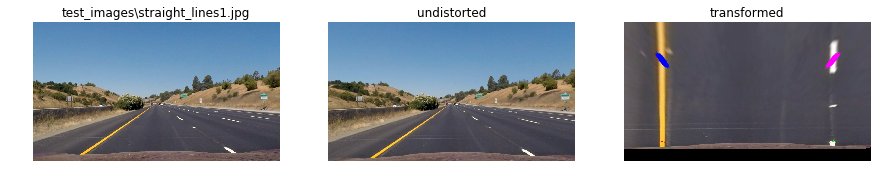

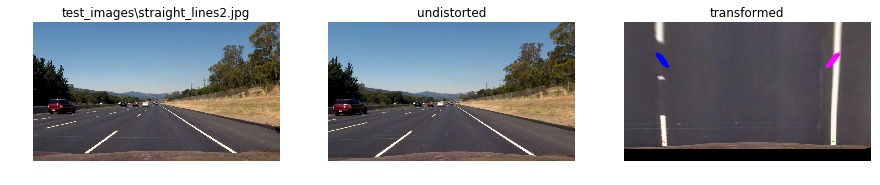

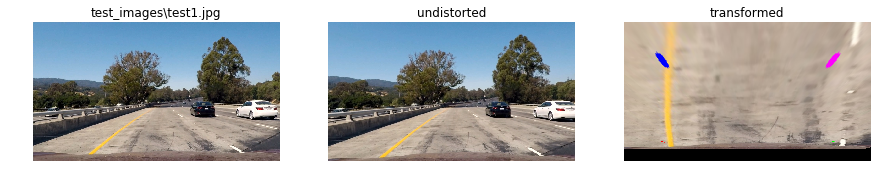

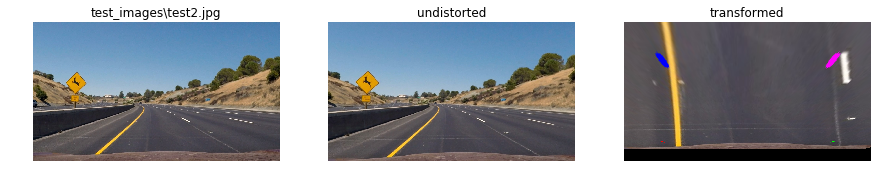

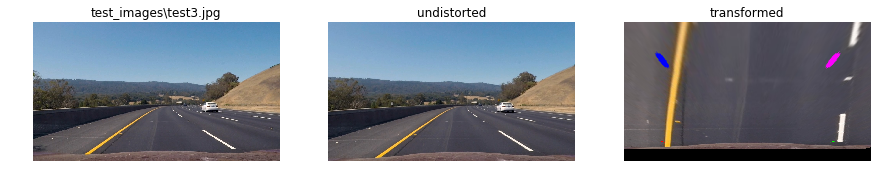

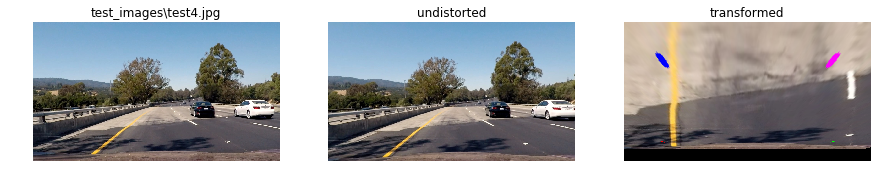

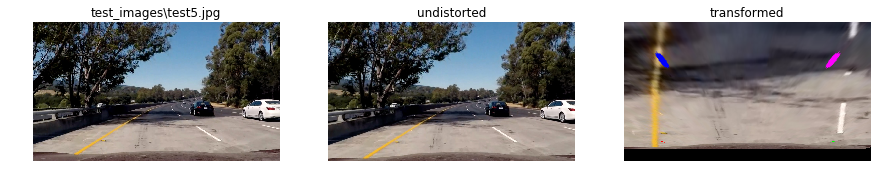

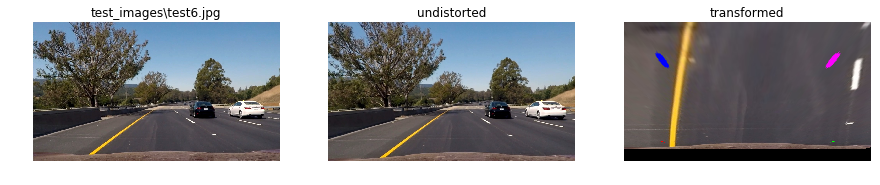

In [26]:
cam_params = pickle.load(open('camera_cal/camera_params.p', 'rb'))
cmtx = cam_params['cmtx']
dCoefs = cam_params['dCoefs']
for fname in glob.glob('test_images/*.jpg'):
    plt.figure(figsize=(15,30))
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')

    undistorted = cv2.undistort(img, cmtx, dCoefs, None, cmtx)
    plt.subplot(1, 3, 2)
    plt.imshow(undistorted)
    plt.title('undistorted')
    plt.axis('off')

    x,y = undistorted.shape[:2][::-1]
    src_transform_pts = np.float32([[286, 666], [1020, 666], [527, 500], [761, 500]])
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,0,255)]
    for pt, col in zip(src_transform_pts, colors):
        cv2.circle(undistorted, tuple(pt), 5, col, -1)
    dst_transform_pts = np.float32([[200, y-100], [x-200, y-100], [200, 200], [x-200, 200]])
    m = cv2.getPerspectiveTransform(src_transform_pts, dst_transform_pts)
    transformed = cv2.warpPerspective(undistorted, m, (x, y))
    plt.subplot(1, 3, 3)
    plt.imshow(transformed)
    plt.title('transformed')
    plt.axis('off')
    plt.show()
    
    cam_params['x'] = x
    cam_params['y'] = y
    cam_params['src_pts'] = src_transform_pts
    cam_params['dst_pts'] = dst_transform_pts
    cam_params['transform'] = m
pickle.dump(cam_params, open('camera_cal/camera_params.p', 'wb'))
    

In [ ]:
def threshold(img, sthresh=(170, 255), xthresh=(20, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_chan = hls[:,:,1]
    s_chan = hls[:,:,2]
    abs_sobelx = np.absolute(cv2.Sobel(l_chan, cv2.CV_64F, 1, 0))
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    xbinary = np.zeros_like(l_chan)
    xbinary[(l_chan >= xthresh[0]) & (l_chan <= xthresh[1])] = 255
    
    sbinary = np.zeros_like(s_chan)
    sbinary[(s_chan >= sthresh[0]) & (s_chan <= sthresh[1])] = 255
    
    return np.bitwise_or(sbinary, xbinary)

cam_params = pickle.load(open('camera_cal/camera_params.p', 'rb'))
m = cam_params['transform']
cmtx = cam_params['cmtx']
dCoefs = cam_params['dCoefs']
x = cam_params['x']
y = cam_params['y']
for fname in glob.glob('test_images/*.jpg'):
    plt.figure(figsize=(15,30))
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, cmtx, dCoefs, None, cmtx) 
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')
    
    thresh = threshold(img)
    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title("thresh")
    plt.axis('off')
    
    transform = cv2.warpPerspective(thresh, m, (x, y))
    plt.subplot(1, 3, 3)
    plt.imshow(transform, cmap='gray')
    plt.title("transform")
    plt.axis('off')
    plt.show
    


In [ ]:
cam_params